In [1]:
library(fpp)
library(fpp2)
library(fGarch)
library(quantmod)
library(psych)
library(rugarch)
library(TSA)
library(ggplot2)

Warning message:
"package 'fpp' was built under R version 3.6.2"Loading required package: forecast
Warning message:
"package 'forecast' was built under R version 3.6.2"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff
Loading required package: fma
Warning message:
"package 'fma' was built under R version 3.6.2"Loading required package: expsmooth
Warning message:
"package 'expsmooth' was built under R version 3.6.2"Loading required package: lmtest
Warning message:
"package 'lmtest' was built under R version 3.6.2"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: tseries
Warning message:
"package 'tseries' was built under R version 3.6.2"Warning message:
"package 'fpp2' was built under R 

In [2]:
getSymbols("^DJI",from='1999-01-01',to='2020-04-08',src='yahoo')

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

Warning message:
"'indexClass<-' is deprecated.
Use 'tclass<-' instead.
See help("Deprecated") and help("xts-deprecated")."

[1] "^DJI"

### Descriptive statistical analysis

In [3]:
dim(DJI)

[1] 5350    6

In [4]:
head(DJI)
tail(DJI)

           DJI.Open DJI.High DJI.Low DJI.Close DJI.Volume DJI.Adjusted
1999-01-04  9184.01  9350.33 9122.47   9184.27   89410000      9184.27
1999-01-05  9184.78  9338.74 9182.98   9311.19   79860000      9311.19
1999-01-06  9315.42  9562.22 9315.42   9544.97  103340000      9544.97
1999-01-07  9542.14  9542.14 9426.02   9537.76   88290000      9537.76
1999-01-08  9538.28  9647.96 9525.41   9643.32  103250000      9643.32
1999-01-11  9643.32  9643.32 9532.61   9619.89   98720000      9619.89

           DJI.Open DJI.High  DJI.Low DJI.Close DJI.Volume DJI.Adjusted
2020-03-31 22208.42 22480.37 21852.08  21917.16  571210000     21917.16
2020-04-01 21227.38 21487.24 20784.43  20943.51  506680000     20943.51
2020-04-02 20819.46 21477.77 20735.02  21413.44  529540000     21413.44
2020-04-03 21285.93 21447.81 20863.09  21052.53  450010000     21052.53
2020-04-06 21693.63 22783.45 21693.63  22679.99  610760000     22679.99
2020-04-07 23537.44 23617.24 22634.45  22653.86  594660000     22653.86

In [5]:
data=DJI[,6]
rt=dailyReturn(data,type="log")
simplertn=dailyReturn(data)

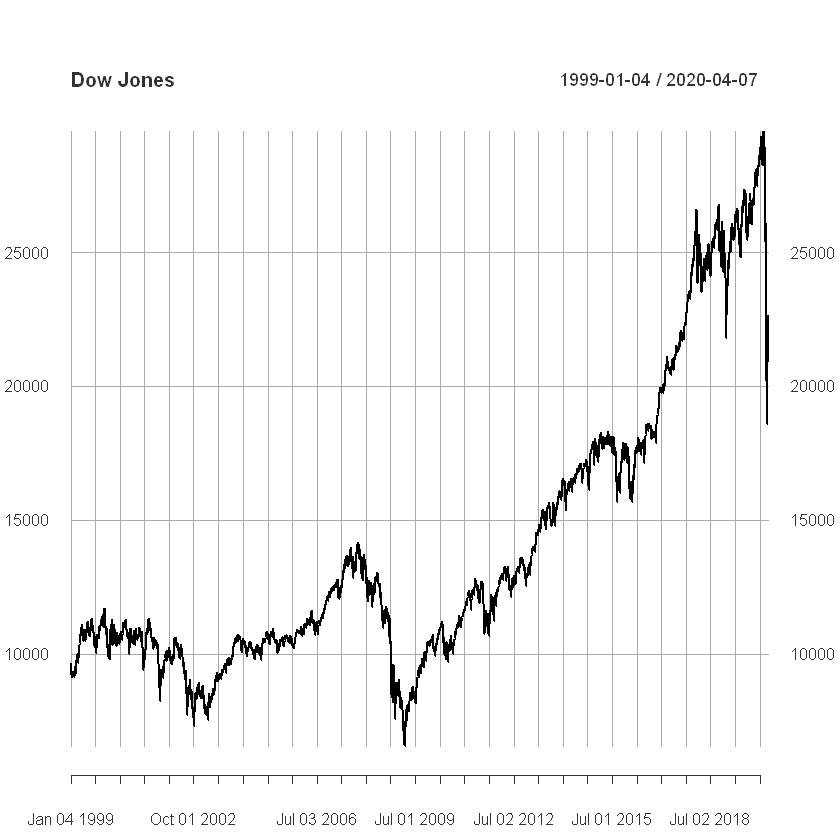

In [6]:
plot(data,xlab="time",ylab="price",main="Dow Jones")

In [7]:
head(rt)

           daily.returns
1999-01-04   0.000000000
1999-01-05   0.013724762
1999-01-06   0.024797337
1999-01-07  -0.000755653
1999-01-08   0.011006848
1999-01-11  -0.002432687

In [45]:
train=rt[1:5000]

In [75]:
test=rt[5001:5350]

In [46]:
tail(train)

           daily.returns
2018-11-06  0.0067836546
2018-11-07  0.0210482632
2018-11-08  0.0004170176
2018-11-09 -0.0077393220
2018-11-12 -0.0234406350
2018-11-13 -0.0039740396

In [82]:
head(test)

           daily.returns
2018-11-14 -8.179618e-03
2018-11-15  8.289525e-03
2018-11-16  4.889362e-03
2018-11-19 -1.569638e-02
2018-11-20 -2.230345e-02
2018-11-21 -3.887863e-05

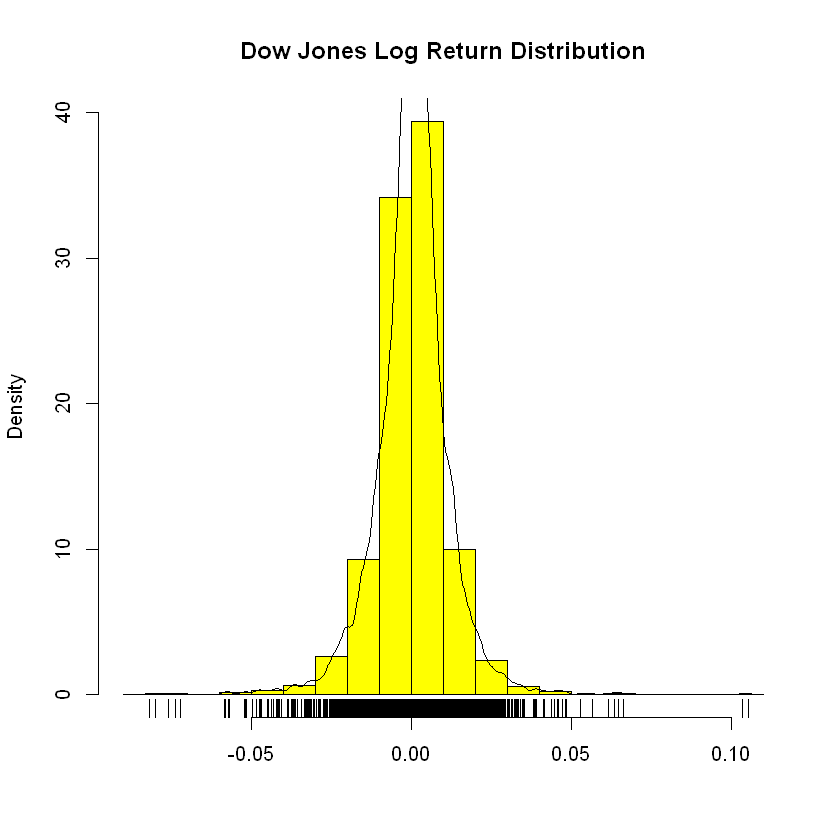

In [47]:
hist(train,main="Dow Jones Log Return Distribution",col="yellow",xlab="",probability=T)
lines(density(train),lwd=1)
rug(train)#Data distribution

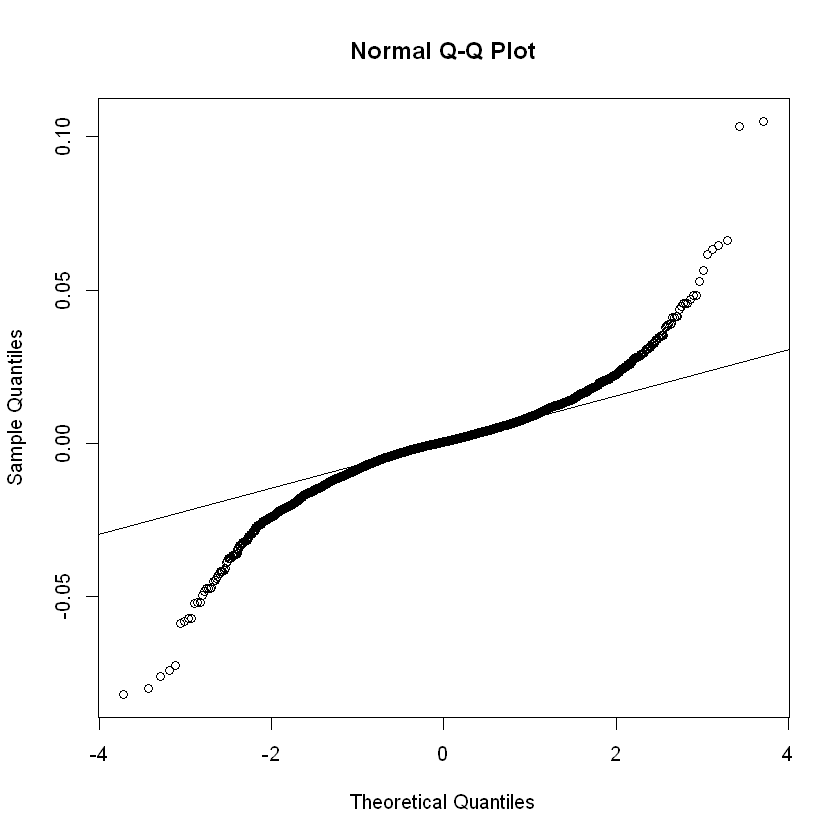

In [48]:
qqnorm(train)
qqline(train)

Financial time series do show sharp peaks and thick tails. Compared to the standard normal distribution, the kurtosis is higher, and the tails of the two segments are thicker, which means more extreme values.

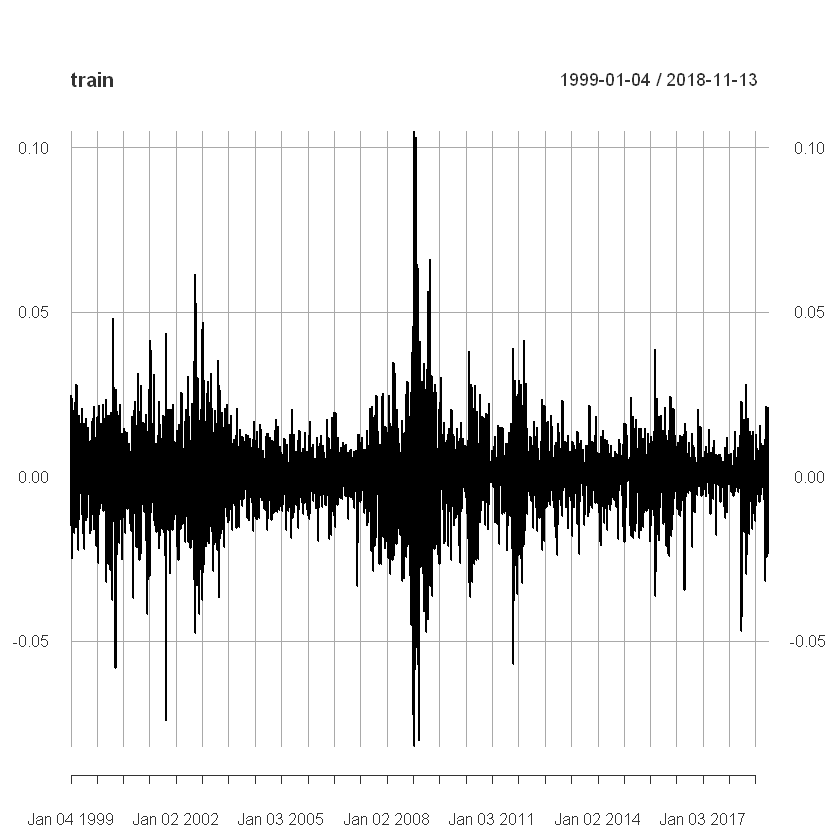

In [49]:
plot(train)

The stock index yield series all show a certain degree of volatility and aggregation within the sample interval, of which the fluctuation range is particularly obvious in 2008

In [50]:
describe(train)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,5000,0.0002025556,0.01127183,0.0004475471,0.0003787733,0.007560403,-0.08200514,0.1050835,0.1870886,-0.1153531,8.093575,0.0001594078


### Pure randomness test & Stationarity test

In [51]:
Box.test(train,type='Ljung-Box')


	Box-Ljung test

data:  train
X-squared = 22.536, df = 1, p-value = 2.062e-06


The test results show that this time series is not a pure random number series, and can be further tested and modeled.

In [52]:
adf.test(train,alt="stationary")

Warning message in adf.test(train, alt = "stationary"):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  train
Dickey-Fuller = -17.336, Lag order = 17, p-value = 0.01
alternative hypothesis: stationary


The test results are consistent with previous research. It is generally believed that the price of financial assets is non-stationary, while the return rate series is stable.

In [53]:
ndiffs(train)

[1] 0

### ARIMA model & ARCH effect test

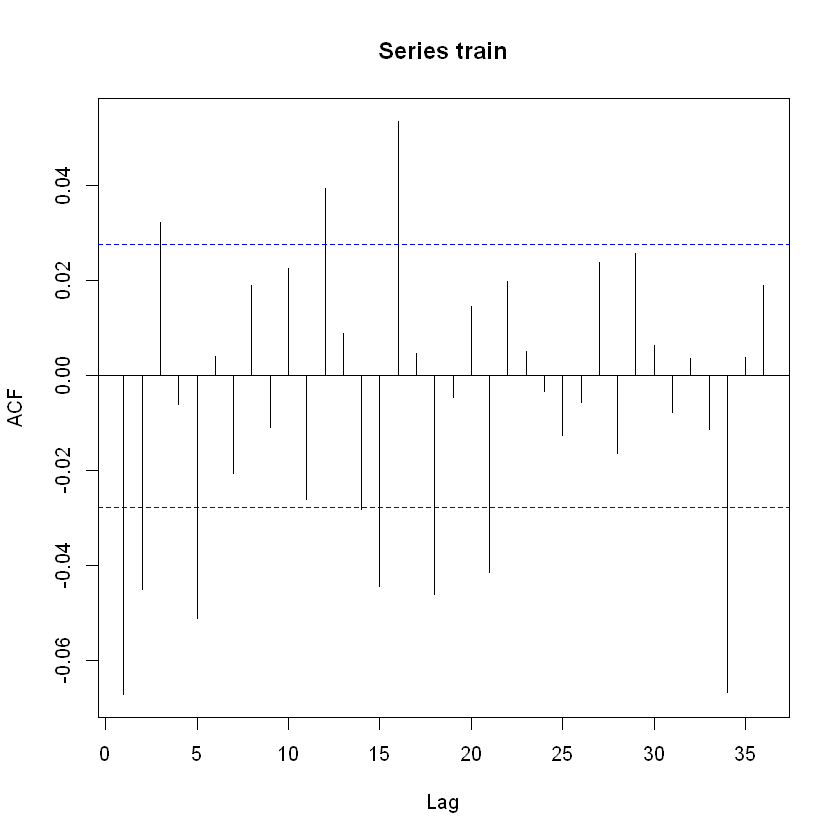

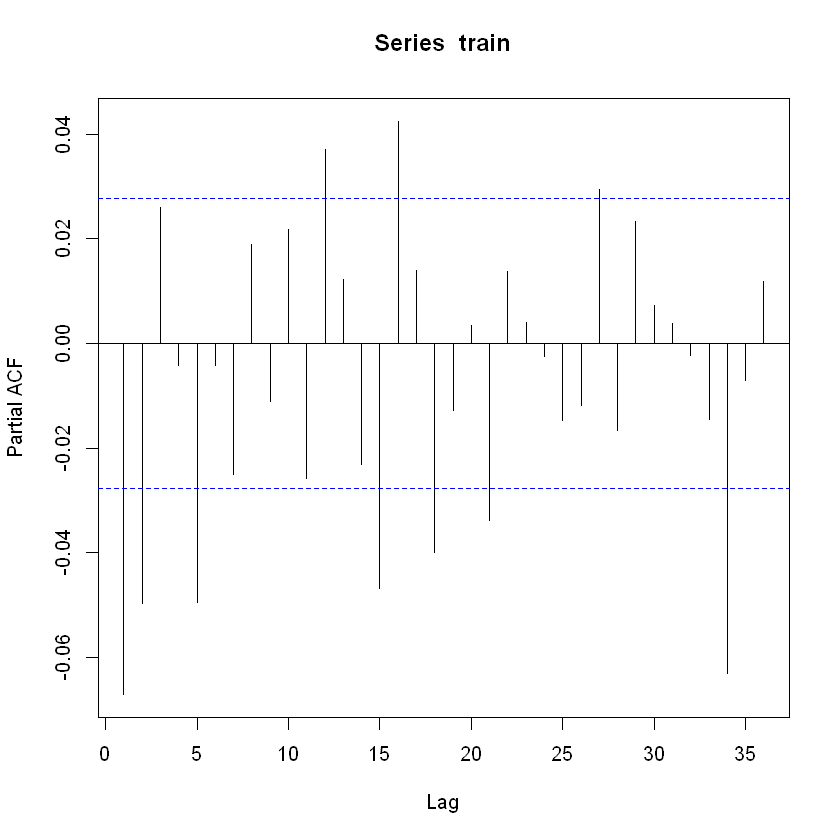

In [54]:
acf(train)
pacf(train)

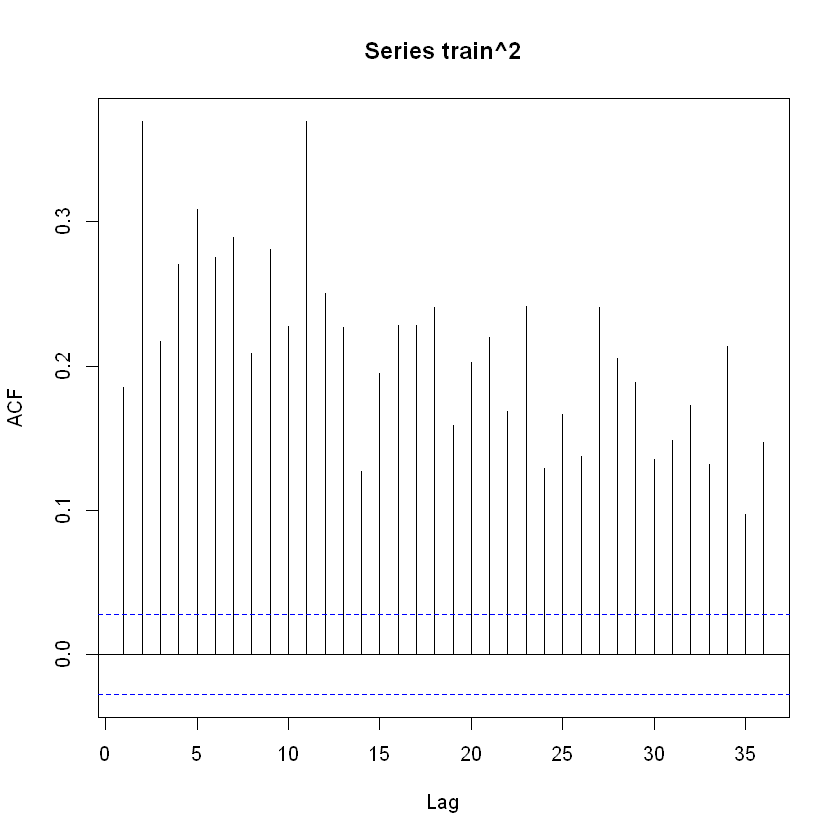

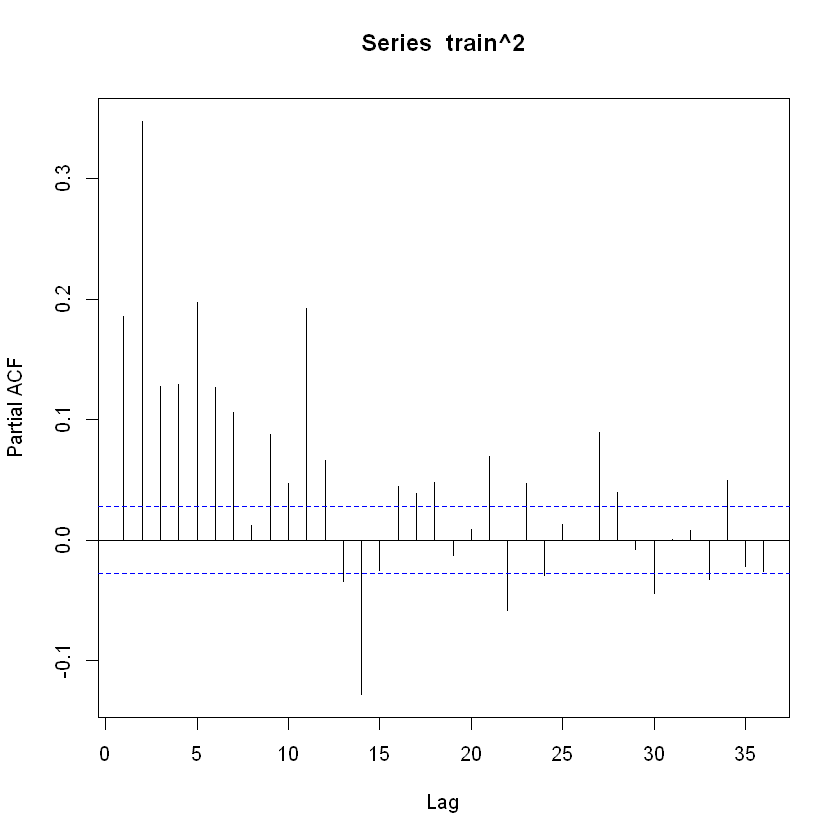

In [55]:
acf(train^2)
pacf(train^2)

In [57]:
auto.arima(train)

Series: train 
ARIMA(5,0,0) with zero mean 

Coefficients:
          ar1      ar2     ar3      ar4      ar5
      -0.0688  -0.0464  0.0238  -0.0073  -0.0491
s.e.   0.0141   0.0142  0.0142   0.0142   0.0141

sigma^2 estimated as 0.0001259:  log likelihood=15357.32
AIC=-30702.64   AICc=-30702.62   BIC=-30663.53

In [62]:
m1=arima(train,order=c(5,0,0))
summary(m1)


Call:
arima(x = train, order = c(5, 0, 0))

Coefficients:
          ar1      ar2     ar3      ar4      ar5  intercept
      -0.0693  -0.0469  0.0233  -0.0077  -0.0495      2e-04
s.e.   0.0141   0.0142  0.0142   0.0142   0.0141      1e-04

sigma^2 estimated as 0.0001257:  log likelihood = 15358.39,  aic = -30704.79

Training set error measures:


Warning message in trainingaccuracy(f, test, d, D):
"test elements must be within sample"

              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


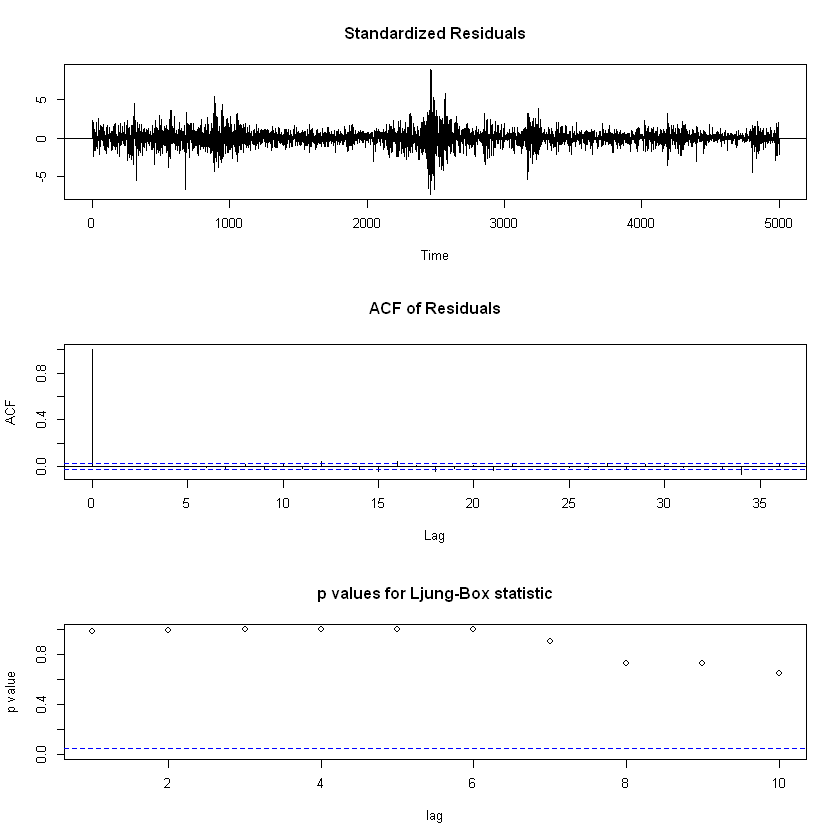

In [63]:
tsdiag(m1)

In [64]:
Box.test(m1$residuals,10,type='Ljung')


	Box-Ljung test

data:  m1$residuals
X-squared = 7.7908, df = 10, p-value = 0.6493


In [65]:
Box.test(m1$residuals^2,10,type='Ljung')


	Box-Ljung test

data:  m1$residuals^2
X-squared = 3767.7, df = 10, p-value < 2.2e-16


In [66]:
m2=garchFit(~arma(5,0)+garch(1,1),data=train,trace=F) 
summary(m2)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(5, 0) + garch(1, 1), data = train, trace = F) 

Mean and Variance Equation:
 data ~ arma(5, 0) + garch(1, 1)
<environment: 0x000000007e8c2428>
 [data = train]

Conditional Distribution:
 norm 

Coefficient(s):
         mu          ar1          ar2          ar3          ar4          ar5  
 6.3479e-04  -4.3036e-02  -6.3542e-03   4.2565e-04  -9.8970e-04  -4.2173e-02  
      omega       alpha1        beta1  
 1.6824e-06   1.0625e-01   8.8043e-01  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      6.348e-04   1.120e-04    5.670 1.43e-08 ***
ar1    -4.304e-02   1.525e-02   -2.823  0.00476 ** 
ar2    -6.354e-03   1.510e-02   -0.421  0.67398    
ar3     4.257e-04   1.494e-02    0.028  0.97726    
ar4    -9.897e-04   1.485e-02   -0.067  0.94688    
ar5    -4.217e-02   1.484e-02   -2.842  0.00448 ** 
omega   1.682e-06   2.547e-07    6.605 3.97e-11 ***
alpha1  1.063e-01   9.036e-

In [67]:
m3=garchFit(~arma(1,0)+garch(1,1), data=train,trace=F) 
summary(m3)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(1, 0) + garch(1, 1), data = train, trace = F) 

Mean and Variance Equation:
 data ~ arma(1, 0) + garch(1, 1)
<environment: 0x000000008844cbb0>
 [data = train]

Conditional Distribution:
 norm 

Coefficient(s):
         mu          ar1        omega       alpha1        beta1  
 6.1007e-04  -4.2246e-02   1.6860e-06   1.0694e-01   8.7978e-01  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      6.101e-04   1.098e-04    5.555 2.77e-08 ***
ar1    -4.225e-02   1.524e-02   -2.772  0.00557 ** 
omega   1.686e-06   2.548e-07    6.617 3.66e-11 ***
alpha1  1.069e-01   9.079e-03   11.779  < 2e-16 ***
beta1   8.798e-01   9.448e-03   93.114  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 16403.4    normalized:  3.28068 

Description:
 Fri Apr 24 22:57:54 2020 by user: x4945 


Standardised Residuals Tests:
                               

In [68]:
m4=garchFit(~arma(5,0)+garch(1,1),data=train,trace=F,cond.dist=c("std")) 
summary(m4)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(5, 0) + garch(1, 1), data = train, cond.dist = c("std"), 
    trace = F) 

Mean and Variance Equation:
 data ~ arma(5, 0) + garch(1, 1)
<environment: 0x0000000088caa9e0>
 [data = train]

Conditional Distribution:
 std 

Coefficient(s):
         mu          ar1          ar2          ar3          ar4          ar5  
 7.5296e-04  -5.0610e-02  -1.4639e-02   1.5047e-03  -1.3433e-02  -4.1226e-02  
      omega       alpha1        beta1        shape  
 1.0127e-06   1.0288e-01   8.9392e-01   6.6089e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      7.530e-04   1.056e-04    7.131 9.96e-13 ***
ar1    -5.061e-02   1.434e-02   -3.529 0.000417 ***
ar2    -1.464e-02   1.455e-02   -1.006 0.314281    
ar3     1.505e-03   1.436e-02    0.105 0.916523    
ar4    -1.343e-02   1.441e-02   -0.932 0.351107    
ar5    -4.123e-02   1.420e-02   -2.903 0.003702 ** 
omega   1.013e-06   2.470e-

In [69]:
m5=garchFit(~arma(1,0)+garch(1,1),data=train,trace=F,cond.dist=c("std")) 
summary(m5)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(1, 0) + garch(1, 1), data = train, cond.dist = c("std"), 
    trace = F) 

Mean and Variance Equation:
 data ~ arma(1, 0) + garch(1, 1)
<environment: 0x000000008b59eea0>
 [data = train]

Conditional Distribution:
 std 

Coefficient(s):
         mu          ar1        omega       alpha1        beta1        shape  
 7.0085e-04  -4.9440e-02   1.0236e-06   1.0308e-01   8.9341e-01   6.6957e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      7.008e-04   1.025e-04    6.834 8.23e-12 ***
ar1    -4.944e-02   1.435e-02   -3.445 0.000571 ***
omega   1.024e-06   2.477e-07    4.132 3.60e-05 ***
alpha1  1.031e-01   1.071e-02    9.627  < 2e-16 ***
beta1   8.934e-01   1.029e-02   86.847  < 2e-16 ***
shape   6.696e+00   6.347e-01   10.549  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 16501.48    normalized:  3.300296 

Description:

In [70]:
m6=garchFit(~arma(5,0)+garch(1,1),data=train,trace=F,cond.dist=c("sstd")) 
summary(m6)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(5, 0) + garch(1, 1), data = train, cond.dist = c("sstd"), 
    trace = F) 

Mean and Variance Equation:
 data ~ arma(5, 0) + garch(1, 1)
<environment: 0x0000000088748ea0>
 [data = train]

Conditional Distribution:
 sstd 

Coefficient(s):
         mu          ar1          ar2          ar3          ar4          ar5  
 6.0912e-04  -6.0643e-02  -2.7372e-02  -3.1429e-03  -2.0968e-02  -4.6338e-02  
      omega       alpha1        beta1         skew        shape  
 9.9925e-07   9.9757e-02   8.9518e-01   9.0487e-01   7.1254e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      6.091e-04   1.091e-04    5.584 2.35e-08 ***
ar1    -6.064e-02   1.443e-02   -4.204 2.63e-05 ***
ar2    -2.737e-02   1.470e-02   -1.862  0.06254 .  
ar3    -3.143e-03   1.438e-02   -0.219  0.82695    
ar4    -2.097e-02   1.441e-02   -1.455  0.14553    
ar5    -4.634e-02   1.411e-02   -3.283  0.00103 ** 

In [71]:
m7=garchFit(~arma(1,0)+garch(1,1),data=train,trace=F,cond.dist=c("sstd")) 
summary(m7)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(1, 0) + garch(1, 1), data = train, cond.dist = c("sstd"), 
    trace = F) 

Mean and Variance Equation:
 data ~ arma(1, 0) + garch(1, 1)
<environment: 0x000000008b42ae68>
 [data = train]

Conditional Distribution:
 sstd 

Coefficient(s):
         mu          ar1        omega       alpha1        beta1         skew  
 5.6069e-04  -5.7586e-02   1.0162e-06   1.0102e-01   8.9395e-01   9.1817e-01  
      shape  
 7.1359e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      5.607e-04   1.071e-04    5.235 1.65e-07 ***
ar1    -5.759e-02   1.442e-02   -3.994 6.49e-05 ***
omega   1.016e-06   2.398e-07    4.238 2.26e-05 ***
alpha1  1.010e-01   1.026e-02    9.850  < 2e-16 ***
beta1   8.939e-01   1.001e-02   89.313  < 2e-16 ***
skew    9.182e-01   1.753e-02   52.384  < 2e-16 ***
shape   7.136e+00   7.200e-01    9.911  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.0

compare the AIC of m3 m5 and m7, we choose m7 which has the lowest AIC as our model.

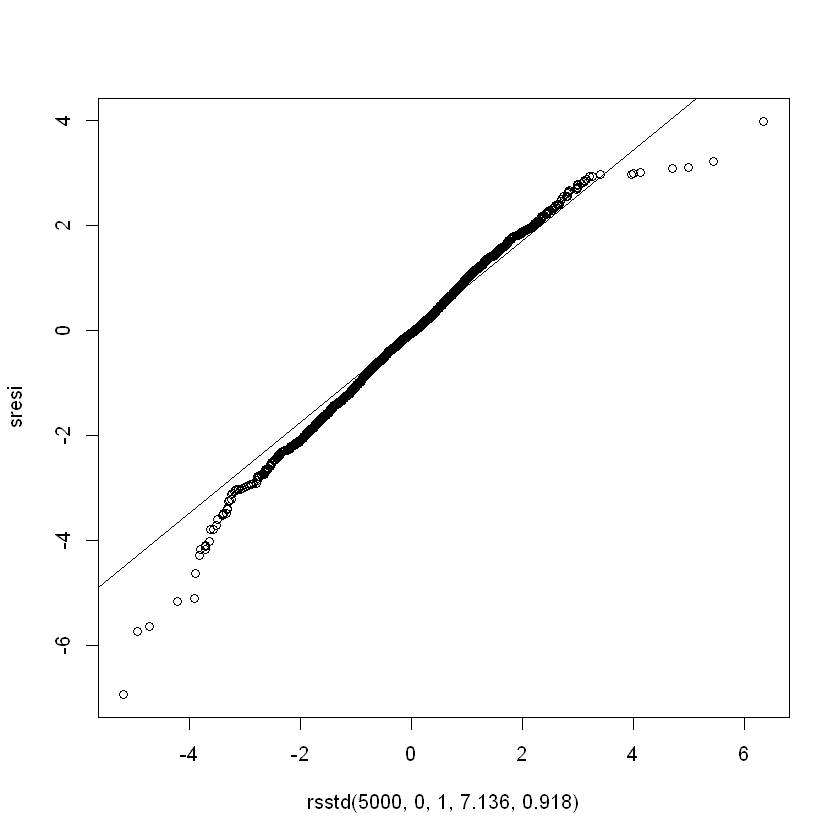

In [72]:
sresi=residuals(m7,standardize=T)
qqplot(rsstd(5000,0,1,7.136,0.918),sresi)
qqline(sresi)


	Box-Pierce test

data:  sresi
X-squared = 2.0584, df = 1, p-value = 0.1514


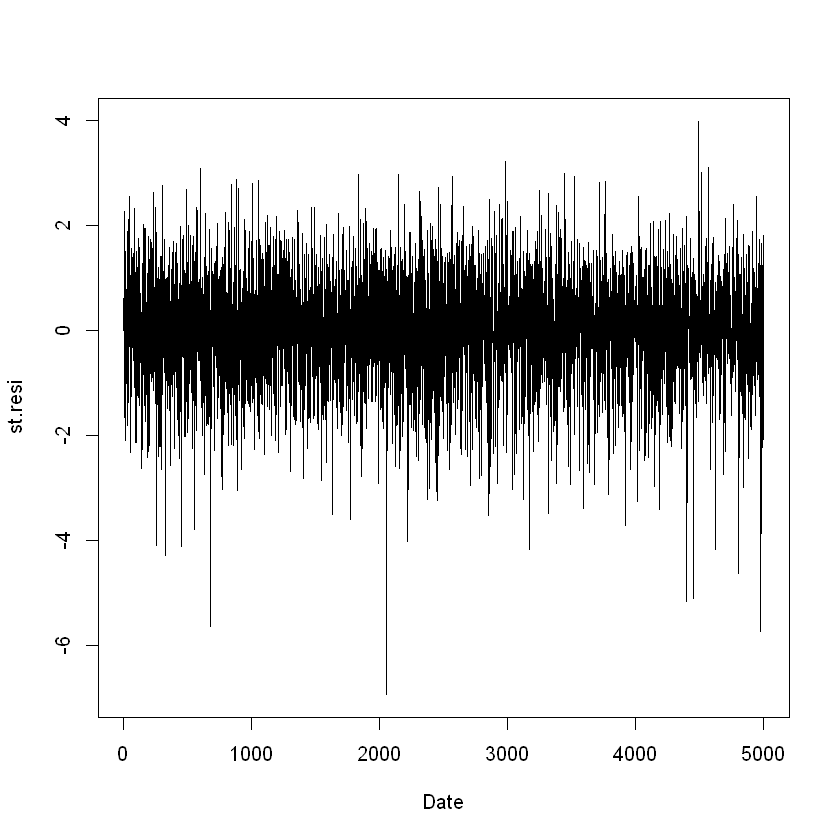

In [73]:
plot(sresi,xlab='Date',ylab='st.resi',type='l')
Box.test(sresi)

The above figure and the box test indicate that the residual do not have autocorrelation.

In [81]:
pr=predict(m7,10)
pr

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
0.0007895384,0.01309113,0.01309113
0.0005152236,0.01311866,0.01309698
0.0005310203,0.01312455,0.01310279
0.0005301106,0.01313035,0.01310858
0.0005301630,0.01313611,0.01311433
0.0005301600,0.01314184,0.01312005
0.0005301601,0.01314753,0.01312574
0.0005301601,0.01315320,0.01313139
0.0005301601,0.01315884,0.01313702


In [83]:
names(pr)

[1] "meanForecast"      "meanError"         "standardDeviation"

In [89]:
count1=0 
for (i in 1:350) 
{   
    data=rt[i:(5000+i), ]
model=garchFit(~arma(1,0)+garch(1,1),data=data,trace=F，cond.dist=c("sstd"))  
pre=predict(model,1)[1] 
if(as.numeric(pre$meanForecast)*(as.numeric(rt[5000+i,1]))>0){     
    count1=count1+1    
} 
}
count1

[1] 141

In [90]:
acc1=count1/350 
acc1

[1] 0.4028571